# Differentiable Physics V: 2D Wave Equation

Lets try to solve the wave equation in 2D using the Mac Cormack method. The wave equation is given by:

$$\frac{\partial ^2 }{\partial t^2} = c^2 \left( \frac{\partial ^2  u}{\partial x^2} + \frac{\partial ^2  u}{\partial y^2} \right)$$

Where $u$ is a scalar field, denoting the height or amount of fluid at a given grid point.




The Mac Cormack Method in 2D becomes:

$$\bar{u}^{n+1} = u^n - 
\frac{\Delta t}{\Delta x} \left( f(u_{i, j}) - f(u_{i-1, j}) \right) - 
\frac{\Delta t}{\Delta y} \left( f(u_{i, j}) - f(u_{i, j-1}) \right)$$

$$u^{n+1} = \frac{1}{2} \left( u^n + \bar{u}^{n+1}\right) - 
\frac{\Delta t}{2 \Delta x} \left( f(\bar{u}^{n+1}_{i,j}) - f(\bar{u}^{n+1}_{i-1,j})  \right) - 
\frac{\Delta t}{2 \Delta y} \left( f(\bar{u}^{n+1}_{i,j}) - f(\bar{u}^{n+1}_{i,j-1})  \right) $$

where the flux function is defined as:

$$f(u) = c \cdot u$$ 

where $c$ denotes the wave speed.

In [1]:
import jax.numpy as jnp
from jax import value_and_grad, jit
from functools import partial

@partial(jit, static_argnames=("c",))
def flux(u : jnp.ndarray, c : jnp.ndarray = -0.2) -> jnp.ndarray:
    return c * u

@partial(jit, static_argnames=("dt", "dx", "dy"))
def mac_cormack_2d(u : jnp.ndarray, dt : float, dx : float, dy : float) -> jnp.ndarray:
    dtdx = dt / dx
    dtdy = dt / dy

    u = u.at[0, :].set(0.0)
    u = u.at[-1, :].set(0.0)
    u = u.at[:, 0].set(0.0)
    u = u.at[:, -1].set(0.0)

    u_pred = u - \
        dtdx * (flux(u) - flux(jnp.roll(u, 1, axis=0))) - \
        dtdy * (flux(u) - flux(jnp.roll(u, 1, axis=1))) 

    u_fwd = 1/2 *( (u + u_pred) - \
        dtdx * (flux(jnp.roll(u_pred, -1, axis=0)) - flux(u_pred)) - \
        dtdy * (flux(jnp.roll(u_pred, -1, axis=1)) - flux(u_pred)) )


    return u_fwd


Lets look at a simple forward simulation:

In [2]:
n_center = 50
n_paddding = 1
n_grid = n_center + 2 * n_paddding
u = jnp.zeros((n_grid, n_grid), dtype=jnp.float32)

k = 4
u = u.at[n_grid//2-k:n_grid//2+k, n_grid//4-k:n_grid//4+k].set(1.0)
u = u.at[n_grid//2-k:n_grid//2+k, 3*n_grid//4-k:3*n_grid//4+k].set(-1.0)


dt = 1.0
dx = 1.0
dy = 1.0

us = []

animation_steps = 50
for i in range(animation_steps):
    u = mac_cormack_2d(u, dt, dx, dy)
    us.append(u.copy())

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()

imp = plt.imshow(us[0], animated=True)
plt.close()

def updatefig(i):
    imp.set_array(us[i])
    return imp,

ani = animation.FuncAnimation(fig, updatefig, frames=range(animation_steps), interval=50, blit=True)
# js 
HTML(ani.to_jshtml())

## Inverse Case

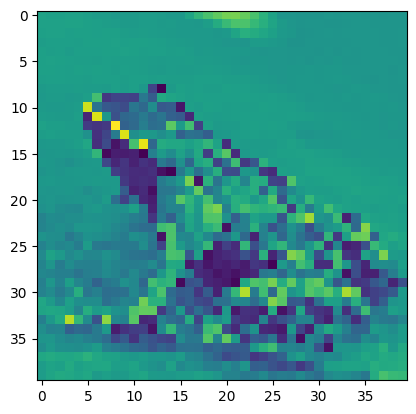

In [12]:
u_target = jnp.array(plt.imread("img/frog.jpg"))
u_target = u_target[0:400 , 150:550, :]
u_target = jnp.mean(u_target, axis=-1)

# downsample to 40 x 40
u_target = u_target[::10, ::10]
n_grid = 40

plt.imshow(u_target)


In [13]:
def animation_loss(
    u : jnp.ndarray, 
    target : jnp.ndarray, 
    dt : float, 
    dx : float, 
    dy : float, 
    iterations : int) -> float:

    for i in range(iterations):
        u = mac_cormack_2d(u, dt, dx, dy)

    return jnp.mean((u - target)**2)


In [14]:
loss_and_grad = value_and_grad(animation_loss, argnums=0)

In [20]:
dt = 1.0
dx = 1.0
dy = 1.0

u0 = jnp.zeros((n_grid, n_grid), dtype=jnp.float32)
u0s = []

optimization_steps = 300
animation_steps = 50

learning_rate = 1500

for i in range(optimization_steps):
    loss, grad = loss_and_grad(u0, u_target, dt, dx, dy, animation_steps)
    u0s.append(u0.copy())
    
    u0 -= learning_rate * grad

    print(f"Loss: {loss}")




Loss: 15461.716796875
Loss: 11654.669921875
Loss: 9771.9375
Loss: 8510.9755859375
Loss: 7604.91650390625
Loss: 6932.95556640625
Loss: 6424.728515625
Loss: 6034.466796875
Loss: 5730.72607421875
Loss: 5491.232421875
Loss: 5299.9013671875
Loss: 5144.9658203125
Loss: 5017.73876953125
Loss: 4911.7568359375
Loss: 4822.1826171875
Loss: 4745.376953125
Loss: 4678.587890625
Loss: 4619.724609375
Loss: 4567.1923828125
Loss: 4519.76611328125
Loss: 4476.50341796875
Loss: 4436.6748046875
Loss: 4399.70703125
Loss: 4365.15673828125
Loss: 4332.669921875
Loss: 4301.9658203125
Loss: 4272.8193359375
Loss: 4245.0478515625
Loss: 4218.5029296875
Loss: 4193.06103515625
Loss: 4168.62060546875
Loss: 4145.095703125
Loss: 4122.41357421875
Loss: 4100.50927734375
Loss: 4079.3310546875
Loss: 4058.829833984375
Loss: 4038.96435546875
Loss: 4019.69580078125
Loss: 4000.99169921875
Loss: 3982.822509765625
Loss: 3965.157470703125
Loss: 3947.974853515625
Loss: 3931.25
Loss: 3914.961181640625
Loss: 3899.089599609375
Loss: 38

In [22]:
us = []

animation_steps = 50
u = u0s[-1]
for i in range(animation_steps):
    u = mac_cormack_2d(u, dt, dx, dy)
    us.append(u.copy())

fig = plt.figure()

imp = plt.imshow(us[0], animated=True)
plt.close()

def updatefig(i):
    imp.set_array(us[i] * 10)
    return imp,

ani = animation.FuncAnimation(fig, updatefig, frames=range(animation_steps), interval=50, blit=True)
# js 
HTML(ani.to_jshtml())